In [4]:
# In a Jupyter Notebook cell
import scanpy as sc
import anndata
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix # For potential sparsification

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# --- Paths ---
# Path to the AnnData object that has corrected RNA in .X and X_multivi in .obsm
# This is the one you saved in the previous step (e.g., from generate_and_add_latent_space.py)
corrected_rna_adata_path = '/home/minhang/mds_project/data/cohort_adata/multiVI_model/adata_multivi_corrected_rna.h5ad'

# Path to your newly generated corrected protein data
protein_parquet_path = '/home/minhang/mds_project/data/cohort_adata/multiVI_model/corrected_protein_expression.parquet.gz'

# Path to the *original* AnnData (needed for original protein names and cell order reference)
original_adata_path = '/home/minhang/mds_project/data/cohort_adata/multiVI_model/adata.h5ad'

# Path for the final updated AnnData object
final_output_adata_path = '/home/minhang/mds_project/data/cohort_adata/multiVI_model/adata_multivi_corrected_rna_protein_latent.h5ad'


# --- Load Data ---
print(f"Loading AnnData with corrected RNA and latent space from: {corrected_rna_adata_path}")
batch_corrected_adata = sc.read_h5ad(corrected_rna_adata_path)
print("AnnData with corrected RNA loaded.")
print(batch_corrected_adata)

print(f"\nLoading corrected protein data from: {protein_parquet_path}")
try:
    protein_df = pd.read_parquet(protein_parquet_path)
    print("Corrected protein DataFrame loaded.")
    print(f"Protein DataFrame shape: {protein_df.shape}")
    print(protein_df.head())
except Exception as e:
    print(f"Error loading protein Parquet file: {e}. Please ensure the file exists and 'pyarrow' is installed.")
    # Handle error appropriately, perhaps by stopping notebook execution for this section

print(f"\nLoading original AnnData for reference (protein names, cell order) from: {original_adata_path}")
adata_mvi_original_ref = sc.read_h5ad(original_adata_path)
adata_mvi_original_ref.var_names_make_unique()
print("Original reference AnnData loaded.")

Loading AnnData with corrected RNA and latent space from: /home/minhang/mds_project/data/cohort_adata/multiVI_model/adata_multivi_corrected_rna.h5ad
AnnData with corrected RNA loaded.
AnnData object with n_obs × n_vars = 192149 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'library', 'exp.ID', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_dsb', 'nFeature_dsb', 'nCount_ADT', 'nFeature_ADT', 'hash.ID', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'Lane', 'patient', 'marker', 'Time', 'batch', 'Tech', 'sample', 'source', 'soup.singlet_posterior', '_indices', '_scvi_batch', '_scvi_labels', 'CN.label', 'predicted.annotation.score', 'predicted.annotation', 'predicted.pseudotime.score', 'predicted.pseudotime', 'timepoint_type'
    var: 'ID', 'modality', 'chr', 'start', 'end'
    uns: 'CN.label_colors', 'Tech_colors', 'draw_graph', 'neighbors', 'patient_colors', 'predicted.annotation_colors', 'sample_colors', 'timepoint_type_colors', 'umap'
    o

In [3]:
protein_validation_passed = True

if 'protein_df' not in locals():
    print("Protein DataFrame ('protein_df') not loaded. Skipping validation.")
    protein_validation_passed = False
else:
    print("\n--- Validating Corrected Protein DataFrame ---")
    
    # 1. Validate Cell Order and Count against batch_corrected_adata
    print("Validating cell order against 'batch_corrected_adata'...")
    if batch_corrected_adata.n_obs != protein_df.shape[0]:
        print(f"ERROR: Cell count mismatch! AnnData: {batch_corrected_adata.n_obs}, Protein DF: {protein_df.shape[0]}")
        protein_validation_passed = False
    elif not all(batch_corrected_adata.obs_names == protein_df.index):
        print("WARNING: Cell order mismatch or different cell names in Protein DF!")
        if set(batch_corrected_adata.obs_names) == set(protein_df.index):
            print("Attempting to reorder Protein DF to match AnnData...")
            try:
                protein_df = protein_df.loc[batch_corrected_adata.obs_names]
                if all(batch_corrected_adata.obs_names == protein_df.index):
                    print("Protein DF cell order successfully matched.")
                else:
                    print("ERROR: Protein DF reordering failed.")
                    protein_validation_passed = False
            except Exception as e:
                print(f"ERROR during protein DF reordering: {e}")
                protein_validation_passed = False
        else:
            print("Cell sets (names) in Protein DF and AnnData are different. Cannot proceed.")
            protein_validation_passed = False
    else:
        print("Protein DF cell order and count are correct relative to batch_corrected_adata.")
    
    # 2. Validate Protein Feature Order and Count against original ADT data
    if protein_validation_passed:
        print("\nValidating protein feature order...")
        if 'ADT' not in adata_mvi_original_ref.obsm or not isinstance(adata_mvi_original_ref.obsm['ADT'], pd.DataFrame):
            print("ERROR: 'ADT' DataFrame not found in original_adata.obsm. Cannot get original protein names for validation.")
            # As a fallback, if you know the number of proteins, you can check that.
            # num_expected_proteins = 170 # From your previous outputs
            # if protein_df.shape[1] != num_expected_proteins:
            #     print(f"ERROR: Protein feature count mismatch! Corrected: {protein_df.shape[1]}, Expected: {num_expected_proteins}")
            #     protein_validation_passed = False
            # else:
            #    print(f"Protein feature count ({protein_df.shape[1]}) matches expected. Assuming order from generation script was correct.")
            protein_validation_passed = False # Be strict if original names aren't available for check
        else:
            original_protein_names = adata_mvi_original_ref.obsm['ADT'].columns.tolist()
            if len(original_protein_names) != protein_df.shape[1]:
                print(f"ERROR: Protein feature count mismatch! Original ADT: {len(original_protein_names)}, Corrected Protein DF: {protein_df.shape[1]}")
                protein_validation_passed = False
            elif not all(original_protein_names == protein_df.columns):
                print("WARNING: Protein feature order mismatch or different protein names in columns.")
                if set(original_protein_names) == set(protein_df.columns):
                    print("Attempting to reorder Protein DF columns...")
                    try:
                        protein_df = protein_df[original_protein_names]
                        if all(original_protein_names == protein_df.columns):
                            print("Protein DF column order successfully matched.")
                        else:
                            print("ERROR: Protein DF column reordering failed.")
                            protein_validation_passed = False
                    except Exception as e:
                        print(f"ERROR during protein DF column reordering: {e}")
                        protein_validation_passed = False
                else:
                    print("Protein feature sets (names) are different. Cannot proceed.")
                    protein_validation_passed = False
            else:
                print("Protein feature order and count are correct.")

if not protein_validation_passed:
    print("Protein data validation failed. Please check before proceeding.")


--- Validating Corrected Protein DataFrame ---
Validating cell order against 'batch_corrected_adata'...
Protein DF cell order and count are correct relative to batch_corrected_adata.

Validating protein feature order...
Protein feature order and count are correct.


Summary statistics for original ADT-CD34 expression:
count    192149.000000
mean         35.854759
std          86.954355
min           0.000000
25%           3.000000
50%           9.000000
75%          24.000000
max       13148.000000
Name: ADT-CD34, dtype: float64


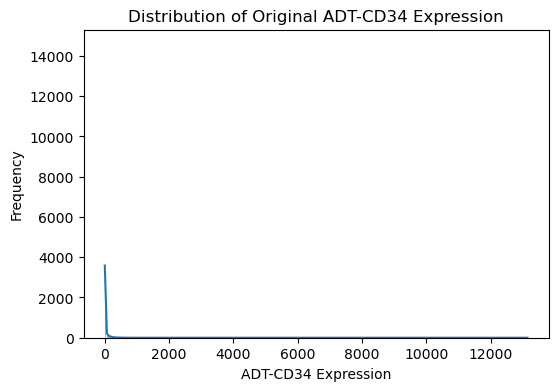

In [7]:
if 'ADT' in adata_mvi_original_ref.obsm and isinstance(adata_mvi_original_ref.obsm['ADT'], pd.DataFrame):
    original_adt_df = adata_mvi_original_ref.obsm['ADT']
    if 'ADT-CD34' in original_adt_df.columns:
        cd34_original_expression = original_adt_df['ADT-CD34']
        
        print("Summary statistics for original ADT-CD34 expression:")
        print(cd34_original_expression.describe())
        
        plt.figure(figsize=(6, 4))
        sns.histplot(cd34_original_expression, kde=True)
        plt.title('Distribution of Original ADT-CD34 Expression')
        plt.xlabel('ADT-CD34 Expression')
        plt.ylabel('Frequency')
        plt.show()
        
        # Example: Define a simple threshold (you might need a more sophisticated one)
        # This is just illustrative. Otsu's method or isotype gating is better.
        # For instance, if values are typically log-normalized or CLR transformed, 
        # positive cells might have values > 1 or 2.
        # threshold_cd34 = 2.0 # Adjust based on your data's scale
        # cd34_positive_original_cells = cd34_original_expression > threshold_cd34
        # percentage_cd34_positive_original = cd34_positive_original_cells.mean() * 100
        # print(f"Percentage of cells with original ADT-CD34 > {threshold_cd34}: {percentage_cd34_positive_original:.2f}%")

        # Note: To rigorously define CD34+ cells, you'd ideally use an isotype control 
        # or a gating strategy based on the distribution (e.g., Otsu's method, as mentioned
        # in the Triana et al. paper [cite: 471, 475, 478]).
        # Your statement "to make sure that I only have CD34+ cells" implies your input
        # material might have been CD34-selected. If so, you'd expect most cells to have high CD34 signal.
        # If it's total bone marrow, you'd expect a smaller percentage.
    else:
        print("ERROR: 'ADT-CD34' column not found in original_adata.obsm['ADT']")
else:
    print("ERROR: 'ADT' DataFrame not found in original_adata.obsm")


Summary statistics for corrected ADT-CD34 expression:
count    192149.000000
mean         47.218204
std          72.233994
min           0.426750
25%           9.270609
50%          24.240223
75%          50.629368
max         965.959167
Name: ADT-CD34, dtype: float64


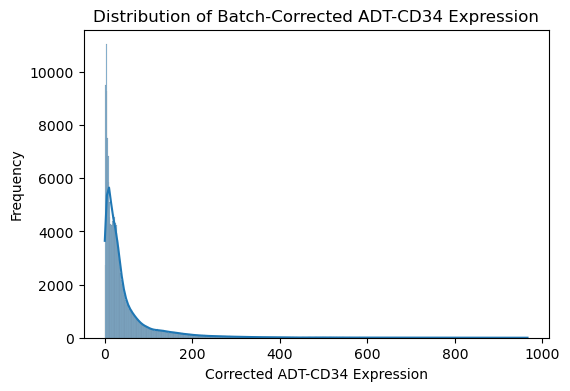

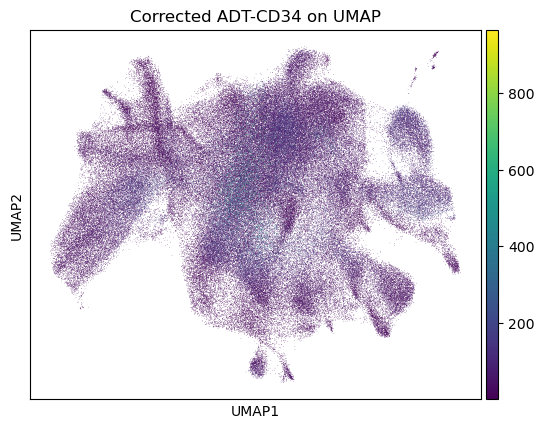

In [5]:
if 'protein_df' in locals() and 'ADT-CD34' in protein_df.columns:
    cd34_corrected_expression = protein_df['ADT-CD34']
    
    print("\nSummary statistics for corrected ADT-CD34 expression:")
    print(cd34_corrected_expression.describe())
    
    plt.figure(figsize=(6, 4))
    sns.histplot(cd34_corrected_expression, kde=True)
    plt.title('Distribution of Batch-Corrected ADT-CD34 Expression')
    plt.xlabel('Corrected ADT-CD34 Expression')
    plt.ylabel('Frequency')
    plt.show()
    
    # You can also overlay this on a UMAP if batch_corrected_adata has one
    if 'X_umap' in batch_corrected_adata.obsm:
        batch_corrected_adata.obs['corrected_ADT_CD34'] = cd34_corrected_expression
        sc.pl.umap(batch_corrected_adata, color='corrected_ADT_CD34', cmap='viridis',
                   title='Corrected ADT-CD34 on UMAP')
else:
    print("Corrected protein DataFrame or 'ADT-CD34' column not available.")

/home/minhang/miniconda3/envs/scvi-env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


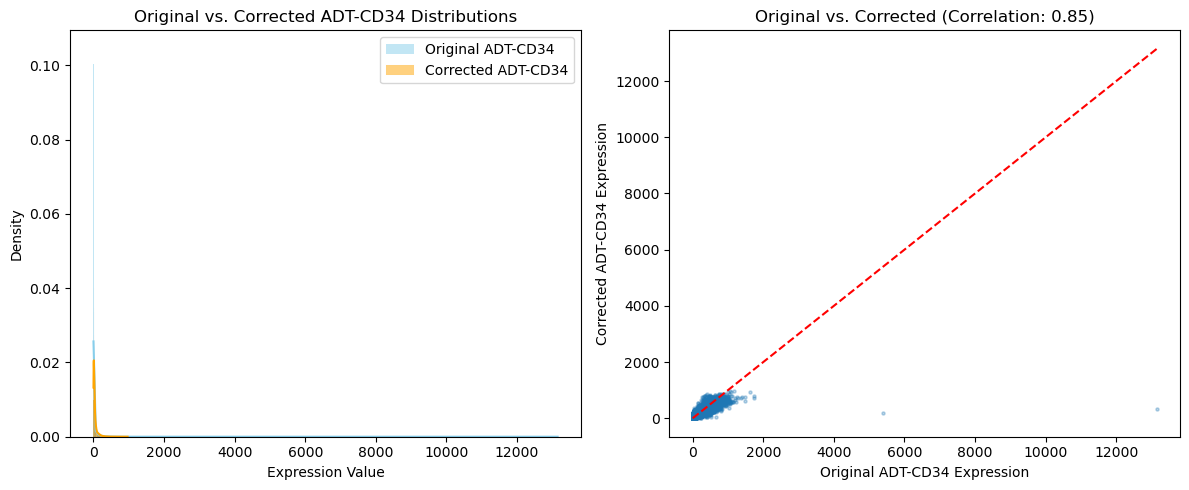

Pearson correlation between original and corrected ADT-CD34 (after handling potential NaNs from reindexing): 0.849


In [8]:
if ('ADT' in adata_mvi_original_ref.obsm and
    isinstance(adata_mvi_original_ref.obsm['ADT'], pd.DataFrame) and
    'ADT-CD34' in adata_mvi_original_ref.obsm['ADT'].columns and
    'protein_df' in locals() and # Check if protein_df was loaded successfully
    'ADT-CD34' in protein_df.columns):

    original_cd34_full = adata_mvi_original_ref.obsm['ADT']['ADT-CD34']
    
    # protein_df.index should match batch_corrected_adata.obs_names after your prior validation steps.
    # Reindex original_cd34_full to match the cell order of batch_corrected_adata (and thus protein_df).
    # This handles cases where the original AnnData might have a different cell order or even a different
    # set of cells, though ideally they should be consistent if batch_corrected_adata is derived from it.
    original_cd34_ordered = original_cd34_full.reindex(batch_corrected_adata.obs_names)

    # corrected_cd34 is already aligned with batch_corrected_adata.obs_names
    corrected_cd34 = protein_df['ADT-CD34']

    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    # Ensure we plot only non-NaN values if reindexing introduced any
    sns.histplot(original_cd34_ordered.dropna(), color='skyblue', label='Original ADT-CD34', kde=True, stat="density", common_norm=False)
    sns.histplot(corrected_cd34.dropna(), color='orange', label='Corrected ADT-CD34', kde=True, stat="density", common_norm=False) # protein_df should not have NaNs here
    plt.title('Original vs. Corrected ADT-CD34 Distributions')
    plt.xlabel('Expression Value')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    # Create a temporary DataFrame for easy dropping of NaNs for correlation and scatter
    comparison_df = pd.DataFrame({
        'original': original_cd34_ordered,
        'corrected': corrected_cd34
    }).dropna()

    correlation = np.corrcoef(comparison_df['original'], comparison_df['corrected'])[0, 1]
    plt.scatter(comparison_df['original'], comparison_df['corrected'], alpha=0.3, s=5)
    plt.xlabel('Original ADT-CD34 Expression')
    plt.ylabel('Corrected ADT-CD34 Expression')
    plt.title(f'Original vs. Corrected (Correlation: {correlation:.2f})')
    
    # Determine overall min and max for identity line after dropping NaNs
    overall_min = min(comparison_df['original'].min(), comparison_df['corrected'].min())
    overall_max = max(comparison_df['original'].max(), comparison_df['corrected'].max())
    plt.plot([overall_min, overall_max], [overall_min, overall_max], color='red', linestyle='--') # Identity line
             
    plt.tight_layout()
    plt.show()
    
    print(f"Pearson correlation between original and corrected ADT-CD34 (after handling potential NaNs from reindexing): {correlation:.3f}")

else:
    print("Could not perform CD34 original vs. corrected comparison due to missing data (e.g., 'ADT' not in obsm, or 'ADT-CD34' column missing).")

In [3]:
# In a Jupyter Notebook cell
if protein_validation_passed and 'protein_df' in locals():
    print("\nAdding corrected protein data to batch_corrected_adata.obsm...")
    # Standard key for protein expression is 'protein_expression' or be specific
    batch_corrected_adata.obsm['X_protein_corrected'] = protein_df.copy() # Store as a DataFrame or .values as NumPy
    print("Corrected protein data added to .obsm['X_protein_corrected'].")
    print(f"Shape of X_protein_corrected: {batch_corrected_adata.obsm['X_protein_corrected'].shape}")
else:
    print("\nSkipping adding protein data due to validation errors or 'protein_df' not loaded.")


Adding corrected protein data to batch_corrected_adata.obsm...
Corrected protein data added to .obsm['X_protein_corrected'].
Shape of X_protein_corrected: (192149, 170)


In [5]:
batch_corrected_adata.obsm['X_protein_corrected'].shape

(192149, 170)

Old code for trying to sparsify RNA data

In [8]:
# In a Jupyter Notebook cell
if 'batch_corrected_adata' in locals():
    print("\n--- Assessing and Optionally Sparsifying RNA Data (batch_corrected_adata.X) ---")
    current_rna_X = batch_corrected_adata.X
    print(f"Current type of batch_corrected_adata.X: {type(current_rna_X)}")

    # Your previous assessment results:
    # Percentage of actual zero values: 0.00%
    # Percentage of values smaller than 1e-05: 56.22%
    
    # Decision Point: Based on 56.22% near-zeros, sparsification is a good option for storage.
    # Let's choose a threshold. 1e-6 is reasonable given the median.
    sparsification_threshold = 1e-6 
    # You could also use 1e-5 if you want to zero out more values.

    print(f"\nSelected threshold for sparsification: {sparsification_threshold}")
    user_choice_to_sparsify = True

    if user_choice_to_sparsify:
        print("Sparsifying RNA data...")
        # Ensure we are working with a NumPy array for the operation
        if not isinstance(current_rna_X, np.ndarray):
            print("Converting .X to dense NumPy array for thresholding...")
            data_to_sparsify = current_rna_X.toarray() if hasattr(current_rna_X, "toarray") else np.array(current_rna_X)
        else:
            data_to_sparsify = current_rna_X.copy() # Work on a copy

        # Apply threshold: set values smaller than threshold (in magnitude) to 0
        data_to_sparsify[np.abs(data_to_sparsify) < sparsification_threshold] = 0
        
        # Convert to CSR sparse matrix
        sparse_X = csr_matrix(data_to_sparsify)
        
        # Calculate new sparsity
        new_percent_zeros = (1 - (sparse_X.nnz / sparse_X.size)) * 100
        print(f"New percentage of zero values after thresholding: {new_percent_zeros:.2f}%")
        
        batch_corrected_adata.X = sparse_X
        print(f"Type of batch_corrected_adata.X after sparsification: {type(batch_corrected_adata.X)}")
        print("RNA data in .X has been sparsified.")
    else:
        print("Skipping RNA data sparsification. .X remains as is (likely dense).")
else:
    print("\nSkipping RNA sparsification step as 'batch_corrected_adata' is not available.")


--- Assessing and Optionally Sparsifying RNA Data (batch_corrected_adata.X) ---
Current type of batch_corrected_adata.X: <class 'numpy.ndarray'>

Selected threshold for sparsification: 1e-06
Sparsifying RNA data...


: 

In [ ]:
type(batch_corrected_adata.X), batch_corrected_adata.X.shape

(numpy.ndarray, (192149, 36601))